In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r '/content/drive/MyDrive/4-2/Machine Learning CSE-471,472/Lab/Offline-2 (Stacking, Bagging)/dataset' '.'
# !pip install scikit-learn

Mounted at /content/drive


# RUN-1

## Imports
---

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# check for Log.txt file existence, if not create it
import os
if not os.path.exists('Log.txt'):
    with open('Log.txt', 'w'): pass

## Constants
---

In [5]:
NULL_HANDLING = 'null_handling'
DUPLICATE_HANDLING = 'duplicate_handling'
ENCODING = 'encoding'
SEED = 40
N_BAGS = 9
DATASET = "telco"

## Logistic Regression Model
---

**Heuristic Function** -> Sigmoid

In [6]:
# x => Feature Vector
# wt => Weight vector for feature i
def heuristic_func(x, wt):
    return 1 / (1 + np.exp(-np.dot(x, wt)))

In [7]:
# Returns the prediction probability (continuous) for the given test data
def predict(x_test, wt):
    y_pred = []
    for x in x_test:
        x = np.insert(x, 1, 0)
        pred_y = heuristic_func(x, wt)
        y_pred.append(pred_y)
    return y_pred

In [33]:
def train_model(x_train, y_train, epochs, batch_size):
    MODEL_DIM = x_train.shape[1]
    # Finetuning required for meta classifier training
    wt = np.zeros(MODEL_DIM + 1)
    alpha, beta, regularizer_type = 0.1, 0.1, 'l1'
    print(f'alpha: {alpha}, beta: {beta}, regularizer_type: {regularizer_type}')

    for epoch in range(epochs):
        grad = np.zeros(MODEL_DIM + 1)

        for k, (x, y) in enumerate(zip(x_train, y_train), 1):
            x = np.insert(x, 1, 0)
            pred_y = heuristic_func(x, wt)

            # Accumulate losses along each feature
            for i in range (1, len(x)):
                grad[i] += (y - pred_y) * x[i]
            grad[0] += (y - pred_y)

            if k % batch_size == 0:
                reg_term = beta * np.sign(wt) if regularizer_type == 'l1' else beta * wt
                wt += alpha * (grad - reg_term)
                grad.fill(0)

        reg_term = beta * np.sign(wt) if regularizer_type == 'l1' else beta * wt
        wt += alpha * (grad - reg_term)

        if epoch % 10 == 0: alpha *= 0.9
    print(f'Epochs --------------------------------- {epochs}')

    return wt

## Accuracy Metrics

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, f1_score

def evaluate_metrics(pred_y, true_y):
    # pred_y = prediction probability
    # true_y = actual label (discrete)
    # Create a confusion matrix

    # Calculate AUROC and AUPR using prediction probability and actual label
    auroc = roc_auc_score(true_y, pred_y)
    aupr = average_precision_score(true_y, pred_y)

    pred_y = [1 if y >= 0.5 else 0 for y in pred_y]
    tn, fp, fn, tp = confusion_matrix(true_y, pred_y).ravel()

    # Calculate sensitivity, specificity, precision, and F1-Score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    f1 = f1_score(true_y, pred_y)  # F1 Score

    return [accuracy, sensitivity, specificity, precision, f1, auroc, aupr]


# Data Preprocessings
---

## RUN-2 **(Methods)**

In [11]:
def load_dataset(dataset_name, path):
    if dataset_name == 'telco':
        df = pd.read_csv(path)
        target = df.columns[-1]
    elif dataset_name == 'adult':
        df = pd.read_csv(path, header=None)
        # List of column names
        column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                        'marital-status', 'occupation', 'relationship', 'race',
                        'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
        df.columns = column_names
        # In this dataset, '?' is considered as unknown or you can say it's missing
        df.replace(' ?', np.nan, inplace=True)
        target = df.columns[-1]
    elif dataset_name == 'credit_card':
        df = pd.read_csv(path)
        target = df.columns[-1]
    else:
        print("Online dataset loaded")
        df = pd.read_csv(path)
        target = df.columns[-1]
    print(f"The target label: {target}", df[target].unique())
    return df, target

def get_non_num_cols(df, target):
    non_num_cols = [col for col in df.select_dtypes(exclude='number').columns if col != target]
    print("Total non-numeric cols:", len(non_num_cols))
    return non_num_cols

def data_cleaning(df, cleaning_type, dataset_type='train', df_prime=None):
    non_num_cols = get_non_num_cols(df, target)

    # NULL === nan, '?'
    if cleaning_type == NULL_HANDLING:
        print("Total null values:", df.isnull().sum().sum())
        # If there are null values in a feature, replace that with the mean and mode for the non-numerical valued columns
        # Except the target column "Churn"
        if dataset_type == 'train':
            df.fillna(df.mean(numeric_only=True), inplace=True)
        else:
            # Don't use mean from the test-set to fill missing values in the test set, use train set for mean, mode
            df.fillna(df_prime.mean(numeric_only=True), inplace=True)

        # Replace null values with the mode of the column (non-numerics)
        for col in non_num_cols:
            if dataset_type == 'train':
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                # Don't use mean from the test-set to fill missing values in the test set, use train set for mean, mode
                df[col] = df[col].fillna(df_prime[col].mode()[0])

        # If there are null values in the target columns, remove those rows
        df.dropna(subset=[target], inplace=True)

    if cleaning_type == DUPLICATE_HANDLING:
        print('Total rows:', df.shape[0])
        print('Total duplicates:', df.duplicated(keep=False).sum())
        print('Can be removed:', df.duplicated(keep='first').sum())
        df.drop_duplicates(inplace=True)
        print('After removing duplicates:', df.shape[0])

def encode_data(features, label):
    non_num_cols = get_non_num_cols(features, '')
    # Features encoding
    for col in non_num_cols:
        features[col] = features[col].astype('category')
        print(col, features[col].nunique())

    # One hot encoding -> Features
    features = pd.get_dummies(features)

    # Label encoding -> Target
    label[label.columns[0]] = LabelEncoder().fit_transform(label[label.columns[0]])
    return features, label

## RUN-3 **(Dataset: ONLINE)**
features, target

In [12]:
DATASET = "B1"
df, target = load_dataset(DATASET, 'B1.csv')

Online dataset loaded
The target label: y [1 0]


### NULL HANDLING

In [14]:
data_cleaning(df, NULL_HANDLING)

Total non-numeric cols: 0
Total null values: 0


### DUPLICATE HANDLING
If duplicate examples are present in the dataset, keep the original

In [15]:
data_cleaning(df, DUPLICATE_HANDLING)

Total non-numeric cols: 0
Total rows: 3000
Total duplicates: 0
Can be removed: 0
After removing duplicates: 3000


### Features, Target SPLIT

In [16]:
df.reset_index(drop=True, inplace=True)  # Apparantly, impacts the corr analysis

features = df.drop(columns=[target])
label = df[[target]].copy()

### ENCODING

In [17]:
# Before one-hot encoding
features.shape

(3000, 2)

In [18]:
features, label = encode_data(features, label)

Total non-numeric cols: 0


In [19]:
# After one-hot encoding
features.shape

(3000, 2)

## RUN-3 **(Dataset: Telco)**
features, target

In [8]:
DATASET = "telco"
df, target = load_dataset(DATASET, 'dataset/telco/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Irrelevent data
print('Irrelevent data:', df.columns[0])
df.drop(columns=[df.columns[0]], inplace=True, axis=1) # Might confuse the model, so drop

The target label: Churn ['No' 'Yes']
Irrelevent data: customerID


**Handling Mismatches**

In [9]:
# Actual data types
# TotalCharges is object, should be float64
mismatch_col = 'TotalCharges'
df[mismatch_col] = pd.to_numeric(df[mismatch_col], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


### NULL HANDLING

In [10]:
data_cleaning(df, NULL_HANDLING)

Total non-numeric cols: 15
Total null values: 11


### DUPLICATE HANDLING
If duplicate examples are present in the dataset, keep the original

In [11]:
data_cleaning(df, DUPLICATE_HANDLING)

Total non-numeric cols: 15
Total rows: 7043
Total duplicates: 42
Can be removed: 22
After removing duplicates: 7021


### Features, Target SPLIT

In [12]:
df.reset_index(drop=True, inplace=True)  # Apparantly, impacts the corr analysis

features = df.drop(columns=[target])
label = df[[target]].copy()

### ENCODING

In [13]:
# Before one-hot encoding
features.shape

(7021, 19)

In [14]:
features, label = encode_data(features, label)

Total non-numeric cols: 15
gender 2
Partner 2
Dependents 2
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4


In [15]:
# After one-hot encoding
features.shape

(7021, 45)

## RUN-3 **(Dataset: adult)**
features, target

**Train-Set**

In [144]:
DATASET = 'adult'
df, target = load_dataset(DATASET, 'dataset/adult/adult.data')
df.info()

The target label: income [' <=50K' ' >50K']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Test-Set**

In [145]:
test_df, target = load_dataset('adult', 'dataset/adult/adult.test')
test_df.info()

The target label: income [' <=50K.' ' >50K.']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


### NULL HANDLING

In [146]:
print("Train-Set")
data_cleaning(df, NULL_HANDLING)

print("\nTest-Set")
data_cleaning(test_df, NULL_HANDLING, dataset_type='test', df_prime=df)

Train-Set
Total non-numeric cols: 8
Total null values: 4262

Test-Set
Total non-numeric cols: 8
Total null values: 2203


In [147]:
# Finding the missing category (native-country) in the test_set
# List of actual categories
actual_categories = [
    'United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada',
    'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan',
    'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras',
    'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam',
    'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic',
    'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary',
    'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia',
    'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong',
    'Holand-Netherlands'
]

# Get unique values from the DataFrame column
unique_values = test_df['native-country'].str.strip().unique()

# Find absent categories
absent_categories = set(actual_categories) - set(unique_values)

print("Absent Categories in the test set:", absent_categories)


Absent Categories in the test set: {'Holand-Netherlands'}


### DUPLICATE HANDLING
If duplicate examples are present in the dataset, keep the original

In [148]:
# Duplicate visualization
# df[df.duplicated(keep='last')].sort_values(by=column_names).head(10)

In [149]:
print("Train-Set")
data_cleaning(df, DUPLICATE_HANDLING)

print("\nTest-Set")
data_cleaning(test_df, DUPLICATE_HANDLING)

Train-Set
Total non-numeric cols: 8
Total rows: 32561
Total duplicates: 47
Can be removed: 24
After removing duplicates: 32537

Test-Set
Total non-numeric cols: 8
Total rows: 16281
Total duplicates: 10
Can be removed: 5
After removing duplicates: 16276


### Features, Target SPLIT

In [150]:
df.reset_index(drop=True, inplace=True) # Apparantly, impacts the corr analysis

features = df.drop(columns=[target])
test_features = test_df.drop(columns=[target])

label = df[[target]].copy()
test_label = test_df[[target]].copy()

### ENCODING

In [151]:
# Before one-hot encoding
print("train:", features.shape)
print("test:", test_features.shape)

train: (32537, 14)
test: (16276, 14)


In [152]:
print("Train-Set")
features, label = encode_data(features, label)

print("\nTest-Set")
test_features, test_label = encode_data(test_features, test_label)

Train-Set
Total non-numeric cols: 8
workclass 8
education 16
marital-status 7
occupation 14
relationship 6
race 5
sex 2
native-country 41

Test-Set
Total non-numeric cols: 8
workclass 8
education 16
marital-status 7
occupation 14
relationship 6
race 5
sex 2
native-country 40


In [153]:
# After one-hot encoding
print("train:", features.shape)
print("test:", test_features.shape)


train: (32537, 105)
test: (16276, 104)


## RUN-3 **(Dataset: creditcard)**
features, target

In [154]:
DATASET = 'credit_card'
df, target = load_dataset(DATASET, 'dataset/credit_card/creditcard.csv')
df.info()

The target label: Class [0 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non

### BALANCING Train-Data

In [155]:
# Separate positive and negative samples
positive_samples = df[df[target] == 1]
negative_samples = df[df[target] == 0]

print("Total positive samples (1):", len(positive_samples))
print("Total negative samples (0):", len(negative_samples))
# Scarce data class is "1"

# Randomly select 20,000 negative samples
negative_samples_selected = negative_samples.sample(n=20000, random_state=SEED)

df = pd.concat([positive_samples, negative_samples_selected])

# Shuffle the resulting DataFrame (optional)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

df.shape

Total positive samples (1): 492
Total negative samples (0): 284315


(20492, 31)

### NULL HANDLING

In [156]:
data_cleaning(df, NULL_HANDLING)

Total non-numeric cols: 0
Total null values: 0


### DUPLICATE HANDLING
If duplicate examples are present in the dataset, keep the original

In [157]:
# Duplicate visualization
df[df.duplicated(keep='last')].sort_values(by=list(df.columns)).head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
5914,46387.0,-2.525765,1.934136,0.803184,1.571913,-1.621559,0.981111,-1.486179,2.180808,-0.069379,-0.663064,0.047970,2.150039,0.294070,0.439862,-2.210522,-1.019211,1.540313,-0.495781,1.540817,-0.180967,-0.148983,-0.410374,0.095628,0.024774,0.047707,-0.402202,-0.213922,-0.042551,9.90,0
1557,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,-5.052502,4.406806,-4.610756,-1.909488,-9.072711,-0.226074,-6.211557,-6.248145,-3.149247,0.051576,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
3081,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,-5.052502,4.406806,-4.610756,-1.909488,-9.072711,-0.226074,-6.211557,-6.248145,-3.149247,0.051576,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
8810,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,-5.052502,4.406806,-4.610756,-1.909488,-9.072711,-0.226074,-6.211557,-6.248145,-3.149247,0.051576,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
9873,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,-5.052502,4.406806,-4.610756,-1.909488,-9.072711,-0.226074,-6.211557,-6.248145,-3.149247,0.051576,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
11828,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,-5.052502,4.406806,-4.610756,-1.909488,-9.072711,-0.226074,-6.211557,-6.248145,-3.149247,0.051576,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
4462,68913.0,-1.444574,0.990996,1.248015,-0.140729,0.102207,2.268415,-0.892379,1.544575,-0.163075,-1.296338,-0.754147,1.263930,1.560613,-0.101130,0.904102,-0.824906,1.004467,-1.819154,-1.094017,-0.250756,0.195424,0.590994,-0.018445,-1.735540,-0.399694,0.434685,-0.210222,-0.015109,6.14,0
7582,68965.0,-10.945028,4.441358,-5.294537,0.062109,-5.195177,-1.075054,-2.628561,4.219429,1.168256,1.545579,-2.086961,2.299629,1.144422,2.000331,-0.739820,1.084244,1.437628,-0.572519,-0.543741,-0.860438,-0.016697,-0.756737,-0.536232,0.480862,0.365185,-0.248012,-4.237346,-1.469759,11.53,0
6804,84204.0,-1.927453,1.827621,-7.019495,5.348303,-2.739188,-2.107219,-5.015848,1.205868,-4.382713,-8.337707,7.190306,-9.424844,-0.223293,-12.875494,-0.071918,-6.299961,-12.719207,-3.740176,0.844060,2.172709,1.376938,-0.792017,-0.771414,-0.379574,0.718717,1.111151,1.277707,0.819081,512.25,1
1199,84204.0,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,-8.099119,7.182967,-9.445943,-0.314620,-12.991466,-0.136359,-6.367524,-12.734394,-3.845130,1.007667,1.129532,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.00,1


In [158]:
data_cleaning(df, DUPLICATE_HANDLING)

Total non-numeric cols: 0
Total rows: 20492
Total duplicates: 48
Can be removed: 27
After removing duplicates: 20465


### Features, Target SPLIT

In [159]:
df.reset_index(drop=True, inplace=True) # Apparantly, impacts the corr analysis

features = df.drop(columns=[target])
label = df[[target]].copy()

### ENCODING

In [160]:
# Before one-hot encoding
features.shape

(20465, 30)

In [161]:
features, label = encode_data(features, label)

Total non-numeric cols: 0


In [162]:
# After one-hot encoding
features.shape

(20465, 30)

# RUN-4

## **SCALING**
Scale the **features** that are not encoded

In [20]:
def scale_data(scaling_type):
    scaler = None
    if scaling_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    return scaler

In [21]:
num_cols = features.select_dtypes(include='number').columns
print(num_cols)

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for col in num_cols:
    scaler = scale_data('minmax')
    features[col] = scaler.fit_transform(features[[col]])
features

Index(['X1', 'X2'], dtype='object')


,X1,X2
0,0.505470,0.657384
1,0.566144,0.102054
2,0.596884,0.668927
3,0.679418,0.833698
4,0.385150,0.317862
...,...,...
2995,0.692566,0.660877
2996,0.463817,0.083045
2997,0.471569,0.087190
2998,0.803880,0.180547


## **TOP FEATURES**
---
Take best correlated features for training

In [22]:
label

,y
0,1
1,0
2,1
3,0
4,1
...,...
2995,1
2996,0
2997,0
2998,0


In [23]:
print("Total features available:", len(features.columns))

features_count = 20 # Default
if DATASET == 'telco':
    features_count = 40
elif DATASET == 'adult':
    features_count = 40
elif DATASET == 'credit_card':
    features_count = 30
corr_series = features.corrwith(label[target])
top_features = corr_series.abs().sort_values(ascending=False).head(features_count)
top_features

Total features available: 2


X1    0.006938
X2    0.002624
dtype: float64

In [24]:
features = features[top_features.index].copy()
if DATASET == 'adult':
    test_features = test_features[top_features.index].copy()
features.shape

(3000, 2)

## **BAGGING**
---
Format: bag -> (features, target)

In [25]:
def create_bags(n, x_train, y_train):
    bags = []
    for _ in range(n):
        bag = pd.concat([x_train, y_train], axis=1).sample(frac=1, replace=True)
        bags.append((bag.drop(columns=target, axis=1), bag[[target]].copy()))
    return bags

# RUN-5
---

In [26]:
def print_performance_metrics(metrics):
    with open('Log.txt', 'a') as sourceFile:
        print(f"Accuracy: {metrics[0]:.4f}", file=sourceFile)
        print(f"Sensitivity: {metrics[1]:.4f}", file=sourceFile)
        print(f"Specificity: {metrics[2]:.4f}", file=sourceFile)
        print(f"Precision: {metrics[3]:.4f}", file=sourceFile)
        print(f"F1-Score: {metrics[4]:.4f}", file=sourceFile)
        print(f"AUROC: {metrics[5]:.4f}", file=sourceFile)
        print(f"AUPR: {metrics[6]:.4f}", file=sourceFile)
        sourceFile.flush()  # Force writing to file

    print("Metrics written to Log.txt")  # Optional message to confirm logging


## Classifiers

In [27]:
def base_train(bags, epochs, batch_size):
    base_classifiers = [] # Weights basically
    default_LR = False

    for i, bag in enumerate(bags):
        features = bag[0].to_numpy().astype('float64')
        targets = bag[1].to_numpy().astype('float64').flatten()

        if default_LR == False:
            model = train_model(features, targets, epochs=epochs, batch_size=batch_size)
            base_classifiers.append(model)
        else:
            model = LogisticRegression()
            model.fit(features, targets)
            base_classifiers.append(model)
        print(f'Base classifier {i+1} trained successfully')

    return base_classifiers

## Meta Classifier
def meta_predict(x_train, y_train, x_test, y_test, epochs, batch_size, bags):
    print("------------Stacking Ensemble-----------")
    
    base_classifiers = base_train(bags, epochs=epochs, batch_size=batch_size)

    meta_dataset, test_dataset = x_train.copy(), x_test.copy()
    test_features_arr, meta_features_arr = x_test.to_numpy().astype('float64'), x_train.to_numpy().astype('float64')

    for model in base_classifiers:
        meta_preds = predict(meta_features_arr, model)
        meta_dataset = pd.concat([meta_dataset, pd.DataFrame(meta_preds)], axis=1)
        test_preds = predict(test_features_arr, model)
        test_dataset = pd.concat([test_dataset, pd.DataFrame(test_preds)], axis=1)

    meta_dataset_arr = meta_dataset.to_numpy().astype('float64')
    meta_model = train_model(meta_dataset_arr, y_train.to_numpy().flatten(), epochs=epochs, batch_size=batch_size)

    test_dataset_arr = test_dataset.to_numpy().astype('float64')
    test_targets_arr = y_test.to_numpy().flatten()
    
    # Testing the meta classifier
    meta_preds = predict(test_dataset_arr, meta_model)

    print_performance_metrics(evaluate_metrics(meta_preds, test_targets_arr))


## Voting Ensemble

In [28]:
def majority_vote_predict(x_test, y_test, epochs, batch_size, bags):
    print("------------Majority Voting Ensemble-----------")
    
    base_classifiers = base_train(bags, epochs=epochs, batch_size=batch_size)

    model_preds = []

    # Collect predictions from each model for every example
    features = x_test.astype('float64').to_numpy()
    targets = y_test.astype('float64').to_numpy().flatten()

    for model in base_classifiers:
        preds_for_model = predict(features, wt=model)
        model_preds.append(preds_for_model)

    preds_per_example = np.array(model_preds).T  # Shape: (num_examples, num_models)

    # Calculate majority vote for each example
    final_preds = []
    for preds in preds_per_example:
        majority_vote = np.mean(preds)  # Majority voting
        final_preds.append(majority_vote)

    print_performance_metrics(evaluate_metrics(final_preds, targets))

## Average LR Model

**Violin Plot**

In [29]:
def violin_plot(metrics_per_classifier):   
    # Convert metrics to a DataFrame for easy plotting
    metrics_array = np.array(metrics_per_classifier)
    metrics_df = pd.DataFrame(metrics_array, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUROC', 'AUPR'])

    # Melt the DataFrame to long format for Seaborn
    metrics_long = metrics_df.melt(var_name='Metric', value_name='Value')

    # Plot a single violin plot for all metrics
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Metric', y='Value', data=metrics_long)
    plt.title('Violin Plots for Performance Metrics of Bagging LR Learners')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [30]:
def average_lr_prediction(x_test, y_test, epochs, batch_size, bags, plot=False):
    print("------------Average LR Ensemble-----------")

    base_classifiers = base_train(bags, epochs=epochs, batch_size=batch_size)

    features = x_test.astype('float64').to_numpy()
    targets = y_test.astype('float64').to_numpy().flatten()

    metrics_per_classifier = []
    # Collect metrics for each base classifier
    for model in base_classifiers:
        preds_for_model = predict(features, wt=model)
        metrics = evaluate_metrics(preds_for_model, targets)
        metrics_per_classifier.append(metrics)

    # Calculate average and stddev for metrics
    metrics_per_classifier = np.array(metrics_per_classifier)
    avg_metrics = np.mean(metrics_per_classifier, axis=0)
    std_metrics = np.std(metrics_per_classifier, axis=0)

    # Define metric names
    metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUROC', 'AUPR']
    
    # Print mean and stddev for each metric
    with open('Log.txt', 'a') as sourceFile:
        for name, avg, std in zip(metric_names, avg_metrics, std_metrics):
            print(f"{name}: {avg:.4f} +- {std:.4f}", file=sourceFile)
        sourceFile.flush()

    # Optional plotting
    if plot:
        metrics_long = pd.DataFrame(metrics_per_classifier, columns=metric_names).melt(var_name='Metric', value_name='Value')
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Metric', y='Value', data=metrics_long)
        plt.title('Violin Plots for Performance Metrics of Bagging LR Learners')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## MODEL RUNS
---
**Data Split** \
Train (train-set): 64% \
Val (train-set): 16% \
Test: 20%

### Data Splits

In [34]:
if DATASET == 'adult':
    x_train, x_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=SEED)
    x_test = test_features.copy()
    y_test = test_label.copy()
else:
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=SEED)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)

x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

yes_classes = y_train[y_train[target] == 1].shape[0]
no_classes = y_train[y_train[target] == 0].shape[0]

with open('Log.txt', 'a') as sourceFile:
    print("---------------------------------------------------------------------------------------------------")
    print(f"Dataset: {DATASET}, size: {features.shape}", file=sourceFile)
    print(f"Train set details | size: {y_train.shape[0]} => yes: {yes_classes}, no: {no_classes}", file=sourceFile)
    print(f"Validation set details | size: {y_val.shape[0]}", file=sourceFile)
    print(f"Test set details | size: {y_test.shape[0]}", file=sourceFile)

bags = create_bags(9, x_train, y_train)
print("Total bags created:", len(bags))

---------------------------------------------------------------------------------------------------
Total bags created: 9


### Train and Test Models

------------Average LR Ensemble-----------
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 1 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 2 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 3 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 4 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 5 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 6 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 7 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs ----------

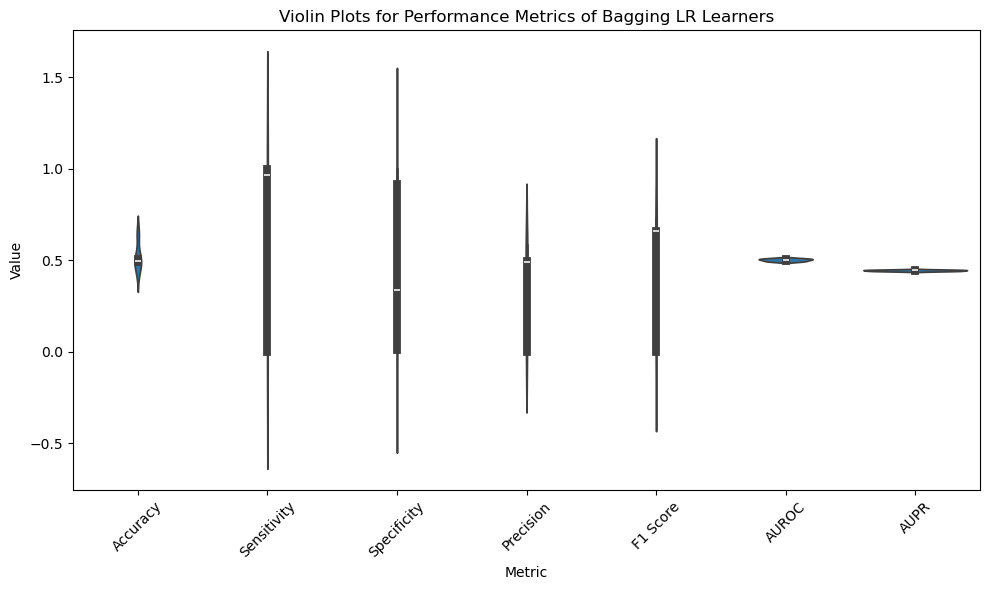

------------Majority Voting Ensemble-----------
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 1 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 2 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 3 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 4 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 5 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 6 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs --------------------------------- 100
Base classifier 7 trained successfully
alpha: 0.1, beta: 0.1, regularizer_type: l1
Epochs -----

In [35]:
with open('Log.txt', 'a') as sourceFile: print("--------------Average LR Ensemble-------------", file=sourceFile)
average_lr_prediction(x_test, y_test, epochs=100, batch_size=200, bags=bags, plot=True)

with open('Log.txt', 'a') as sourceFile: print("--------------Majority Voting Ensemble-------------", file=sourceFile)
majority_vote_predict(x_test, y_test, epochs=100, batch_size=200, bags=bags)

with open('Log.txt', 'a') as sourceFile: print("--------------Stacking Ensemble-------------", file=sourceFile)
meta_predict(x_val, y_val, x_test, y_test, epochs=100, batch_size=200, bags=bags)

In [36]:
# sourceFile.close()

In [37]:
# use the lr from scikit learn to measure accuracy
# lr = LogisticRegression()
# lr.fit(x_train, y_train)
# y_pred = lr.predict(x_test)
# print(accuracy_score(y_test, y_pred))